In [1]:
from google.colab import files
uploaded = files.upload()


Saving test.csv to test.csv
Saving train.csv to train.csv


CV平均スコア: 0.8024919967359236
提出ファイルを作成しました


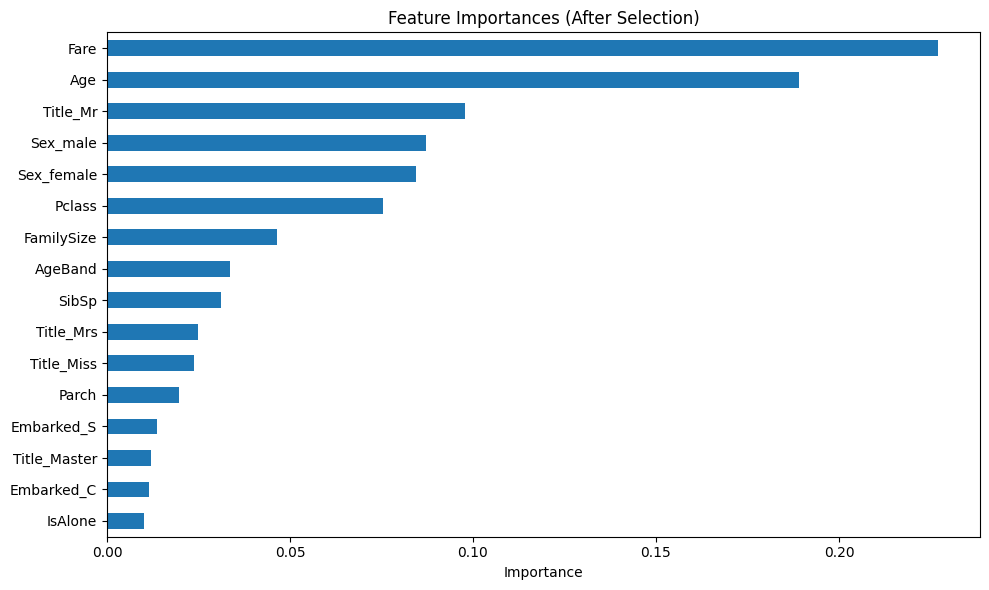

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# データ読み込み
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
test_df_raw = test_df.copy()

# 不要な列を削除
drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin']
train_df = train_df.drop(drop_cols, axis=1)
test_df = test_df.drop(drop_cols, axis=1)

# 欠損値補完
train_df["Age"] = train_df["Age"].fillna(train_df["Age"].median())
test_df["Age"] = test_df["Age"].fillna(test_df["Age"].median())
train_df["Embarked"] = train_df["Embarked"].fillna(train_df["Embarked"].mode()[0])
test_df["Fare"] = test_df["Fare"].fillna(test_df["Fare"].median())

# Title抽出関数
def extract_title(name):
    return name.split(",")[1].split(".")[0].strip()

# Titleを抽出して新しい列に
train_titles = pd.read_csv("train.csv")["Name"].apply(extract_title)
test_titles = pd.read_csv("test.csv")["Name"].apply(extract_title)

# レアな称号をまとめる
def simplify_title(title):
    if title in ['Mr']:
        return 'Mr'
    elif title in ['Miss', 'Mlle']:
        return 'Miss'
    elif title in ['Mrs', 'Mme']:
        return 'Mrs'
    elif title == 'Master':
        return 'Master'
    else:
        return 'Rare'

train_df["Title"] = train_titles.apply(simplify_title)
test_df["Title"] = test_titles.apply(simplify_title)

# 特徴量追加
for df in [train_df, test_df]:
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df["IsAlone"] = (df["FamilySize"] == 1).astype(int)
    df["AgeBand"] = pd.cut(df["Age"], 5, labels=False)

# ワンホットエンコーディング
train_df = pd.get_dummies(train_df, columns=["Sex", "Embarked", "Title"])
test_df = pd.get_dummies(test_df, columns=["Sex", "Embarked", "Title"])

# カラムを揃える
for col in train_df.columns:
    if col not in test_df.columns and col != "Survived":
        test_df[col] = 0
test_df = test_df[train_df.drop("Survived", axis=1).columns]

# 特徴量・目的変数に分離
X_train = train_df.drop("Survived", axis=1)
y_train = train_df["Survived"]
X_test = test_df

# 一度モデル学習して特徴量重要度を取得
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)
importances = pd.Series(model.feature_importances_, index=X_train.columns)

# 重要度が0.01未満の特徴を削除
threshold = 0.01
selected_features = importances[importances >= threshold].index.tolist()
X_train = X_train[selected_features]
X_test = X_test[selected_features]

# 再学習
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# クロスバリデーション
cv_score = cross_val_score(model, X_train, y_train, cv=5)
print("CV平均スコア:", cv_score.mean())

# 予測
y_test_pred = model.predict(X_test)

# 提出ファイル
submission = pd.DataFrame({
    "PassengerId": test_df_raw["PassengerId"],
    "Survived": y_test_pred
})
submission.to_csv("submission.csv", index=False)
print("提出ファイルを作成しました")

# 特徴量重要度可視化
plt.figure(figsize=(10, 6))
importances[selected_features].sort_values().plot(kind='barh')
plt.title("Feature Importances (After Selection)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


<>:16: SyntaxWarning: invalid escape sequence '\.'
<>:16: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-656836690.py:16: SyntaxWarning: invalid escape sequence '\.'
  df["Title"] = df["Name"].str.extract("([A-Za-z]+)\.", expand=False)


CV平均スコア: 0.8002322515849603
提出ファイルを作成しました


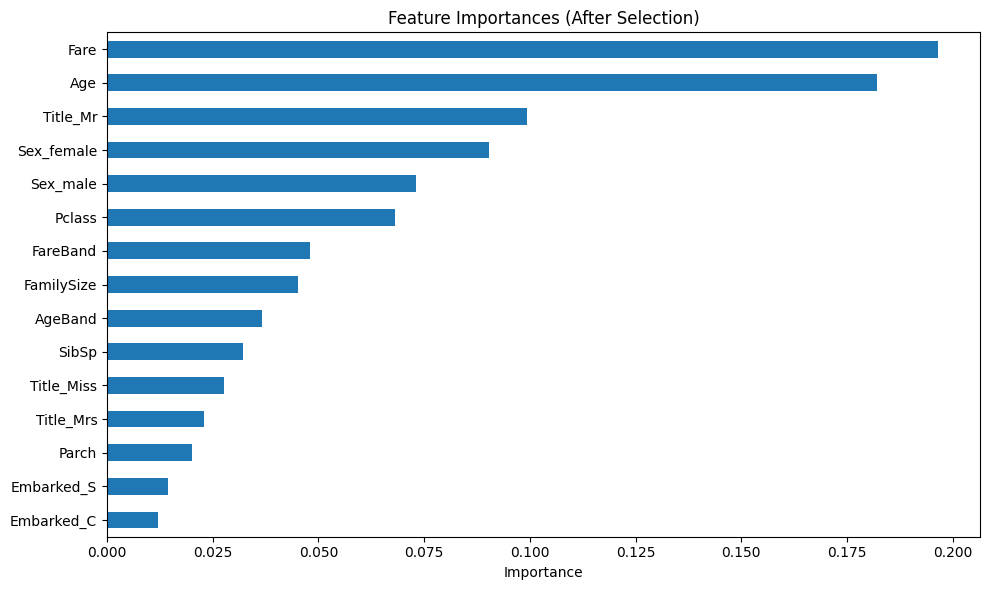

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# データ読み込み
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
test_df_raw = test_df.copy()

# ---------------------
# Title（敬称）抽出
# ---------------------
for df in [train_df, test_df]:
    df["Title"] = df["Name"].str.extract("([A-Za-z]+)\.", expand=False)
    df["Title"] = df["Title"].replace(['Lady', 'Countess', 'Capt', 'Col',
        'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df["Title"] = df["Title"].replace(['Mlle', 'Ms'], 'Miss')
    df["Title"] = df["Title"].replace('Mme', 'Mrs')

# 不要な列を削除
drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin']
train_df = train_df.drop(drop_cols, axis=1)
test_df = test_df.drop(drop_cols, axis=1)

# ---------------------
# 欠損値補完
# ---------------------
age_median_by_title = train_df.groupby('Title')['Age'].median()
for title, age_median in age_median_by_title.items():
    train_df.loc[(train_df['Age'].isnull()) & (train_df['Title'] == title), 'Age'] = age_median
    test_df.loc[(test_df['Age'].isnull()) & (test_df['Title'] == title), 'Age'] = age_median
train_df["Embarked"] = train_df["Embarked"].fillna(train_df["Embarked"].mode()[0])
test_df["Fare"] = test_df["Fare"].fillna(test_df["Fare"].median())

# ---------------------
# 特徴量追加
# ---------------------
for df in [train_df, test_df]:
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df["IsAlone"] = (df["FamilySize"] == 1).astype(int)
    df["AgeBand"] = pd.cut(df["Age"], 5, labels=False)
    df["FareBand"] = pd.qcut(df["Fare"], 5, labels=False)  # 運賃を5分割

# ---------------------
# ワンホットエンコーディング
# ---------------------
train_df = pd.get_dummies(train_df, columns=["Sex", "Embarked", "Title"])
test_df = pd.get_dummies(test_df, columns=["Sex", "Embarked", "Title"])

# ---------------------
# カラムを揃える
# ---------------------
for col in train_df.columns:
    if col not in test_df.columns and col != "Survived":
        test_df[col] = 0
test_df = test_df[train_df.drop("Survived", axis=1).columns]

# ---------------------
# 特徴量・目的変数に分離
# ---------------------
X_train = train_df.drop("Survived", axis=1)
y_train = train_df["Survived"]
X_test = test_df

# ---------------------
# 特徴量重要度で削減
# ---------------------
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
importances = pd.Series(model.feature_importances_, index=X_train.columns)

threshold = 0.01
selected_features = importances[importances >= threshold].index.tolist()
X_train = X_train[selected_features]
X_test = X_test[selected_features]

# ---------------------
# 再学習・評価
# ---------------------
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
cv_score = cross_val_score(model, X_train, y_train, cv=5)
print("CV平均スコア:", cv_score.mean())

# ---------------------
# 予測・提出ファイル作成
# ---------------------
y_test_pred = model.predict(X_test)
submission = pd.DataFrame({
    "PassengerId": test_df_raw["PassengerId"],
    "Survived": y_test_pred
})
submission.to_csv("submission.csv", index=False)
print("提出ファイルを作成しました")

# ---------------------
# 特徴量重要度の可視化
# ---------------------
plt.figure(figsize=(10, 6))
importances[selected_features].sort_values().plot(kind='barh')
plt.title("Feature Importances (After Selection)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# データ読み込み
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
test_df_raw = test_df.copy()

# ---------------------
# Title（敬称）抽出
# ---------------------
for df in [train_df, test_df]:
    df["Title"] = df["Name"].str.extract("([A-Za-z]+)\.", expand=False)
    df["Title"] = df["Title"].replace(['Lady', 'Countess', 'Capt', 'Col',
        'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df["Title"] = df["Title"].replace(['Mlle', 'Ms'], 'Miss')
    df["Title"] = df["Title"].replace('Mme', 'Mrs')

# 不要な列を削除
drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin']
train_df = train_df.drop(drop_cols, axis=1)
test_df = test_df.drop(drop_cols, axis=1)

# ---------------------
# 欠損値補完
# ---------------------
# train_df["Age"] = train_df["Age"].fillna(train_df["Age"].median())
# test_df["Age"] = test_df["Age"].fillna(test_df["Age"].median())
# 改善案：敬称（Title）ごとの年齢の中央値で補完
age_median_by_title = train_df.groupby('Title')['Age'].median()
for title, age_median in age_median_by_title.items():
    train_df.loc[(train_df['Age'].isnull()) & (train_df['Title'] == title), 'Age'] = age_median
    test_df.loc[(test_df['Age'].isnull()) & (test_df['Title'] == title), 'Age'] = age_median
train_df["Embarked"] = train_df["Embarked"].fillna(train_df["Embarked"].mode()[0])
test_df["Fare"] = test_df["Fare"].fillna(test_df["Fare"].median())

# ---------------------
# 特徴量追加
# ---------------------
for df in [train_df, test_df]:
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df["IsAlone"] = (df["FamilySize"] == 1).astype(int)
    df["AgeBand"] = pd.cut(df["Age"], 5, labels=False)

# ---------------------
# ワンホットエンコーディング
# ---------------------
train_df = pd.get_dummies(train_df, columns=["Sex", "Embarked", "Title"])
test_df = pd.get_dummies(test_df, columns=["Sex", "Embarked", "Title"])

# ---------------------
# カラムを揃える
# ---------------------
for col in train_df.columns:
    if col not in test_df.columns and col != "Survived":
        test_df[col] = 0
test_df = test_df[train_df.drop("Survived", axis=1).columns]

# ---------------------
# 特徴量・目的変数に分離
# ---------------------
X_train = train_df.drop("Survived", axis=1)
y_train = train_df["Survived"]
X_test = test_df

# ---------------------
# 特徴量重要度で削減
# ---------------------
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
importances = pd.Series(model.feature_importances_, index=X_train.columns)

threshold = 0.01
selected_features = importances[importances >= threshold].index.tolist()
X_train = X_train[selected_features]
X_test = X_test[selected_features]

# ---------------------
# 再学習・評価
# ---------------------
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
cv_score = cross_val_score(model, X_train, y_train, cv=5)
print("CV平均スコア:", cv_score.mean())

# ---------------------
# 予測・提出ファイル作成
# ---------------------
y_test_pred = model.predict(X_test)
submission = pd.DataFrame({
    "PassengerId": test_df_raw["PassengerId"],
    "Survived": y_test_pred
})
submission.to_csv("submission.csv", index=False)
print("提出ファイルを作成しました")

# ---------------------
# 特徴量重要度の可視化
# ---------------------
plt.figure(figsize=(10, 6))
importances[selected_features].sort_values().plot(kind='barh')
plt.title("Feature Importances (After Selection)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


<>:16: SyntaxWarning: invalid escape sequence '\.'
<>:16: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-2966501776.py:16: SyntaxWarning: invalid escape sequence '\.'
  df["Title"] = df["Name"].str.extract("([A-Za-z]+)\.", expand=False)


FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

CV平均スコア: 0.8103383340656581
提出ファイルを作成しました


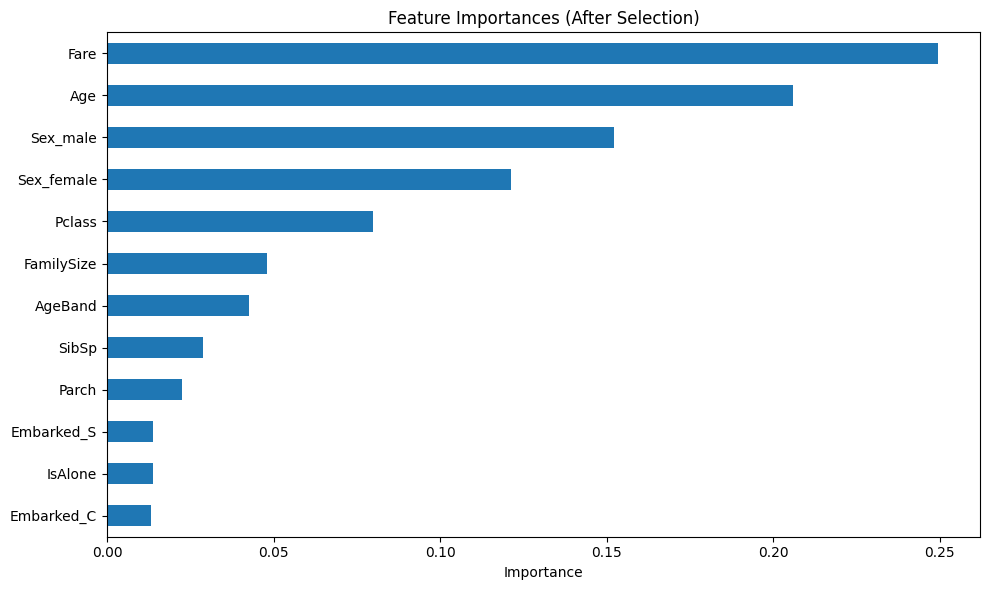

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# データ読み込み
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
test_df_raw = test_df.copy()

# 不要な列を削除
drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin']
train_df = train_df.drop(drop_cols, axis=1)
test_df = test_df.drop(drop_cols, axis=1)

# 欠損値補完
train_df["Age"] = train_df["Age"].fillna(train_df["Age"].median())
test_df["Age"] = test_df["Age"].fillna(test_df["Age"].median())
train_df["Embarked"] = train_df["Embarked"].fillna(train_df["Embarked"].mode()[0])
test_df["Fare"] = test_df["Fare"].fillna(test_df["Fare"].median())

# 特徴量追加
for df in [train_df, test_df]:
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df["IsAlone"] = (df["FamilySize"] == 1).astype(int)
    df["AgeBand"] = pd.cut(df["Age"], 5, labels=False)

# ワンホットエンコーディング
train_df = pd.get_dummies(train_df, columns=["Sex", "Embarked"])
test_df = pd.get_dummies(test_df, columns=["Sex", "Embarked"])

# カラムを揃える
for col in train_df.columns:
    if col not in test_df.columns and col != "Survived":
        test_df[col] = 0
test_df = test_df[train_df.drop("Survived", axis=1).columns]

# 特徴量・目的変数に分離
X_train = train_df.drop("Survived", axis=1)
y_train = train_df["Survived"]
X_test = test_df

# 一度モデル学習して特徴量重要度を取得
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
importances = pd.Series(model.feature_importances_, index=X_train.columns)

# 重要度が0.01未満の特徴を削除
threshold = 0.01
selected_features = importances[importances >= threshold].index.tolist()
X_train = X_train[selected_features]
X_test = X_test[selected_features]

# 再学習
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# クロスバリデーション
cv_score = cross_val_score(model, X_train, y_train, cv=5)
print("CV平均スコア:", cv_score.mean())

# 予測
y_test_pred = model.predict(X_test)

# 提出ファイル
submission = pd.DataFrame({
    "PassengerId": test_df_raw["PassengerId"],
    "Survived": y_test_pred
})
submission.to_csv("submission.csv", index=False)
print("提出ファイルを作成しました")

# 特徴量重要度可視化
plt.figure(figsize=(10, 6))
importances[selected_features].sort_values().plot(kind='barh')
plt.title("Feature Importances (After Selection)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


CV平均スコア: 0.8047329106772958
提出ファイルを作成しました


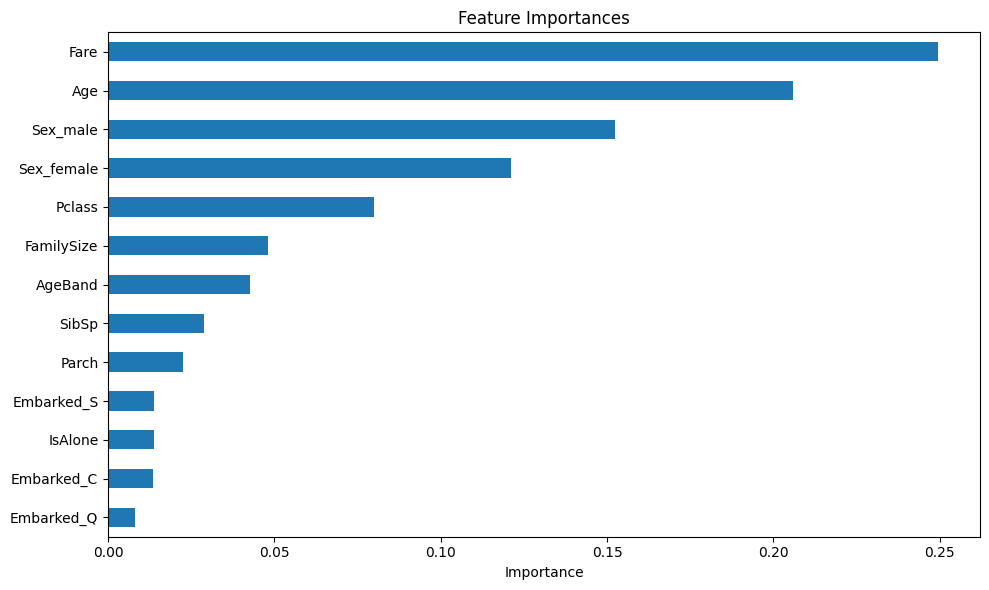

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# データ読み込み
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
test_df_raw = test_df.copy()  # PassengerId 保持用

# 不要な列を削除
train_df = train_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

# 欠損値補完
train_df["Age"] = train_df["Age"].fillna(train_df["Age"].median())
test_df["Age"] = test_df["Age"].fillna(test_df["Age"].median())
train_df["Embarked"] = train_df["Embarked"].fillna(train_df["Embarked"].mode()[0])
test_df["Fare"] = test_df["Fare"].fillna(test_df["Fare"].median())

# 特徴量追加
for df in [train_df, test_df]:
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df["IsAlone"] = (df["FamilySize"] == 1).astype(int)
    df["AgeBand"] = pd.cut(df["Age"], 5, labels=False)

# ワンホットエンコーディング
train_df = pd.get_dummies(train_df, columns=["Sex", "Embarked"])
test_df = pd.get_dummies(test_df, columns=["Sex", "Embarked"])

# カラム揃え（testに不足があれば補う）
for col in train_df.columns:
    if col not in test_df.columns and col != "Survived":
        test_df[col] = 0
test_df = test_df[train_df.drop("Survived", axis=1).columns]

# 特徴量・目的変数に分離
X_train = train_df.drop("Survived", axis=1)
y_train = train_df["Survived"]
X_test = test_df

# モデル学習
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# クロスバリデーションで評価
cv_score = cross_val_score(model, X_train, y_train, cv=5)
print("CV平均スコア:", cv_score.mean())

# テストデータ予測
y_test_pred = model.predict(X_test)

# 提出ファイル作成
submission = pd.DataFrame({
    "PassengerId": test_df_raw["PassengerId"],
    "Survived": y_test_pred
})
submission.to_csv("submission.csv", index=False)
print("提出ファイルを作成しました")

# 特徴量の重要度を取得・可視化
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
plt.figure(figsize=(10, 6))
feat_importances.sort_values().plot(kind='barh')
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# データ読み込み
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# 不要な列を削除
train_df = train_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

# 欠損値の補完
train_df["Age"] = train_df["Age"].fillna(train_df["Age"].median())
test_df["Age"] = test_df["Age"].fillna(test_df["Age"].median())
train_df["Embarked"] = train_df["Embarked"].fillna(train_df["Embarked"].mode()[0])
test_df["Fare"] = test_df["Fare"].fillna(test_df["Fare"].median())

# ワンホットエンコーディング
train_df = pd.get_dummies(train_df, columns=["Sex", "Embarked"])
test_df = pd.get_dummies(test_df, columns=["Sex", "Embarked"])

# 特徴量と目的変数に分割
X_train = train_df.drop("Survived", axis=1)
y_train = train_df["Survived"]

# カラム一致の確認
print("カラム一致:", set(X_train.columns) == set(test_df.columns))

# テストデータ（予測用）
X_test = test_df

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# モデルの作成と学習
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 予測（訓練データで）
y_pred = model.predict(X_train)
print("訓練データでの精度:", accuracy_score(y_train, y_pred))

# 元のテストデータの PassengerId を再取得
test_df_raw = pd.read_csv("test.csv")
y_test_pred = model.predict(X_test)

submission = pd.DataFrame({
    "PassengerId": test_df_raw["PassengerId"],
    "Survived": y_test_pred
})

submission.to_csv("submission.csv", index=False)
print("提出ファイルを作成しました")


カラム一致: True
訓練データでの精度: 0.8002244668911336
提出ファイルを作成しました


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# データ読み込み
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# 保存用にPassengerIdだけ別に保持
test_df_raw = test_df.copy()
passenger_ids = test_df_raw["PassengerId"]

# 不要な列を削除
train_df = train_df.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1)
test_df = test_df.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1)

# 欠損値の補完
train_df["Age"] = train_df["Age"].fillna(train_df["Age"].median())
test_df["Age"] = test_df["Age"].fillna(test_df["Age"].median())
train_df["Embarked"] = train_df["Embarked"].fillna(train_df["Embarked"].mode()[0])
test_df["Fare"] = test_df["Fare"].fillna(test_df["Fare"].median())

# 特徴量エンジニアリング：FamilySize
train_df["FamilySize"] = train_df["SibSp"] + train_df["Parch"] + 1
test_df["FamilySize"] = test_df["SibSp"] + test_df["Parch"] + 1

# 特徴量エンジニアリング：IsAlone
train_df["IsAlone"] = (train_df["FamilySize"] == 1).astype(int)
test_df["IsAlone"] = (test_df["FamilySize"] == 1).astype(int)

# 年齢をビンで分けてカテゴリ化（AgeBand）
train_df["AgeBand"] = pd.cut(train_df["Age"], bins=[0, 16, 32, 48, 64, 80], labels=[0, 1, 2, 3, 4])
test_df["AgeBand"] = pd.cut(test_df["Age"], bins=[0, 16, 32, 48, 64, 80], labels=[0, 1, 2, 3, 4])
train_df["AgeBand"] = train_df["AgeBand"].astype(int)
test_df["AgeBand"] = test_df["AgeBand"].astype(int)

# ワンホットエンコーディング（ダミー変数化）
train_df = pd.get_dummies(train_df, columns=["Sex", "Embarked"])
test_df = pd.get_dummies(test_df, columns=["Sex", "Embarked"])

# カラムを揃える（訓練とテストで同じ列にする）
missing_cols = set(train_df.columns) - set(test_df.columns) - {"Survived"}
for col in missing_cols:
    test_df[col] = 0
test_df = test_df[train_df.drop("Survived", axis=1).columns]

# 特徴量と目的変数に分割
X_train = train_df.drop("Survived", axis=1)
y_train = train_df["Survived"]
X_test = test_df

# モデルの作成と学習
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 精度評価（交差検証）
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print(f"交差検証スコアの平均: {cv_scores.mean():.4f}")

# 予測（訓練データで）
y_pred_train = model.predict(X_train)
print("訓練データでの精度:", accuracy_score(y_train, y_pred_train))

# テストデータで予測
y_test_pred = model.predict(X_test)

# 提出ファイルの作成
submission = pd.DataFrame({
    "PassengerId": passenger_ids,
    "Survived": y_test_pred
})
submission.to_csv("submission.csv", index=False)
print("提出ファイルを作成しました")


交差検証スコアの平均: 0.8047
訓練データでの精度: 0.9797979797979798
提出ファイルを作成しました


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# データ読み込み
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
test_df_raw = test_df.copy()

# 不要な列を削除
train_df = train_df.drop(['Name', 'Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Name', 'Ticket', 'Cabin'], axis=1)

# 欠損値補完
train_df["Age"] = train_df["Age"].fillna(train_df["Age"].median())
test_df["Age"] = test_df["Age"].fillna(test_df["Age"].median())
train_df["Embarked"] = train_df["Embarked"].fillna(train_df["Embarked"].mode()[0])
test_df["Fare"] = test_df["Fare"].fillna(test_df["Fare"].median())

# 特徴量追加
for df in [train_df, test_df]:
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df["IsAlone"] = (df["FamilySize"] == 1).astype(int)
    df["AgeBand"] = pd.cut(df["Age"], 5, labels=False)

# ワンホットエンコーディング
train_df = pd.get_dummies(train_df, columns=["Sex", "Embarked"])
test_df = pd.get_dummies(test_df, columns=["Sex", "Embarked"])

# カラム揃え（testに不足があれば補う）
for col in train_df.columns:
    if col not in test_df.columns and col != "Survived":
        test_df[col] = 0
test_df = test_df[train_df.drop("Survived", axis=1).columns]

# 特徴量・目的変数に分離
X_train = train_df.drop("Survived", axis=1)
y_train = train_df["Survived"]
X_test = test_df

# モデル学習
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# クロスバリデーションで評価
cv_score = cross_val_score(model, X_train, y_train, cv=5)
print("CV平均スコア:", cv_score.mean())

# テストデータ予測
y_test_pred = model.predict(X_test)

# 提出ファイル作成
submission = pd.DataFrame({
    "PassengerId": test_df_raw["PassengerId"],
    "Survived": y_test_pred
})
submission.to_csv("submission.csv", index=False)
print("提出ファイルを作成しました")


CV平均スコア: 0.7980541083422258
提出ファイルを作成しました


CV平均スコア: 0.7980541083422258
提出ファイルを作成しました


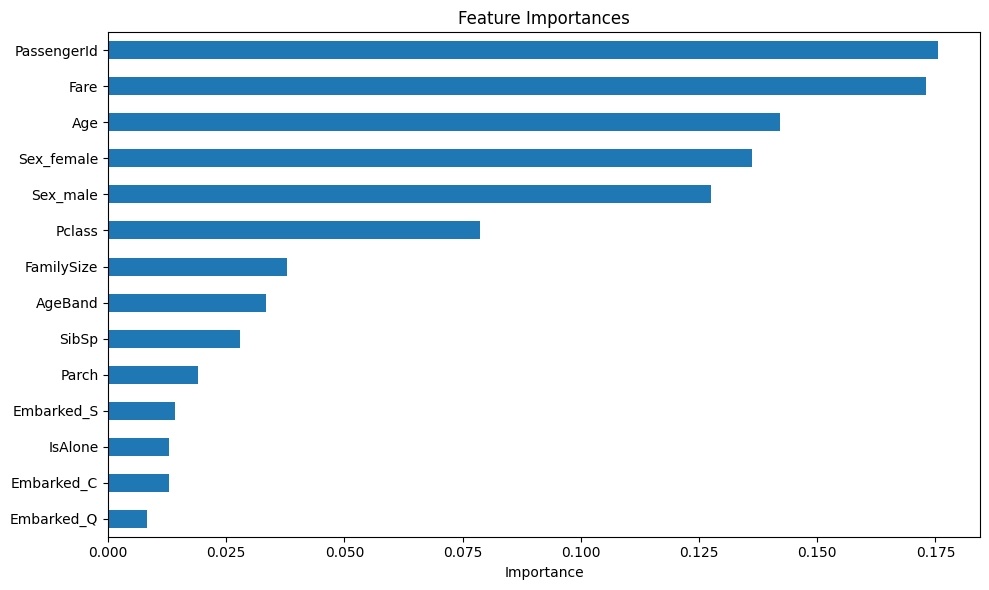

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# データ読み込み
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
test_df_raw = test_df.copy()

# 不要な列を削除
train_df = train_df.drop(['Name', 'Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Name', 'Ticket', 'Cabin'], axis=1)

# 欠損値補完
train_df["Age"] = train_df["Age"].fillna(train_df["Age"].median())
test_df["Age"] = test_df["Age"].fillna(test_df["Age"].median())
train_df["Embarked"] = train_df["Embarked"].fillna(train_df["Embarked"].mode()[0])
test_df["Fare"] = test_df["Fare"].fillna(test_df["Fare"].median())

# 特徴量追加
for df in [train_df, test_df]:
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df["IsAlone"] = (df["FamilySize"] == 1).astype(int)
    df["AgeBand"] = pd.cut(df["Age"], 5, labels=False)

# ワンホットエンコーディング
train_df = pd.get_dummies(train_df, columns=["Sex", "Embarked"])
test_df = pd.get_dummies(test_df, columns=["Sex", "Embarked"])

# カラム揃え（testに不足があれば補う）
for col in train_df.columns:
    if col not in test_df.columns and col != "Survived":
        test_df[col] = 0
test_df = test_df[train_df.drop("Survived", axis=1).columns]

# 特徴量・目的変数に分離
X_train = train_df.drop("Survived", axis=1)
y_train = train_df["Survived"]
X_test = test_df

# モデル学習
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# クロスバリデーションで評価
cv_score = cross_val_score(model, X_train, y_train, cv=5)
print("CV平均スコア:", cv_score.mean())

# テストデータ予測
y_test_pred = model.predict(X_test)

# 提出ファイル作成
submission = pd.DataFrame({
    "PassengerId": test_df_raw["PassengerId"],
    "Survived": y_test_pred
})
submission.to_csv("submission.csv", index=False)
print("提出ファイルを作成しました")

import matplotlib.pyplot as plt

# 特徴量の重要度を取得
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)

# 小さい順に並べて棒グラフで表示
plt.figure(figsize=(10, 6))
feat_importances.sort_values().plot(kind='barh')
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()
